In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard


import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import sys
import os

In [2]:
# Preview packages version
print(f"python: {sys.version} \n")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"scikit learn: {sklearn.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"keras: {keras.__version__}")


python: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)] 

numpy: 1.23.5
pandas: 1.5.3
matplotlib: 3.7.0
seaborn: 0.12.2
scikit learn: 1.2.1
tensorflow: 2.14.0
keras: 2.14.0


In [3]:
class visualization:
    labels = ["Normal", "Anomaly"]
    def draw_confusion_matrix(self, y, y_pred):
        matrix = confusion_matrix(y_true=y, y_pred=y_pred)
        
        plt.figure(figsize=(7,5))
        colors =['orange', 'green']
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels,
                   cmap=colors, annot=True, fmt='d')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        
    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error':error, 'true':y}).groupby('true')
        
        figure, axes = plt.subplots(figsize=(12, 8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, linestyle='',
                      marker='x' if name == 1 else 'o',
                      color='r' if name == 1 else 'g',
                      label='Anomaly' if name == 1 else 'Normal'
                      )
        axes.hlines(threshold, xmin=axes.get_xlim()[0], xmax=axes.get_xlim()[1],
                   colors='b', zorder=100, label='Threshold')
        axes.legend()

        plt.title("Anomalies")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    def draw_error(self, error, threshold):
        figure, axes = plt.subplots(figsize=(12, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
        plt.hlines(threshold, xmin=0, xmax=len(error)-1,
                   colors='b', zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
        

In [4]:
df = pd.read_csv('../data/creditcard.csv')

In [5]:
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

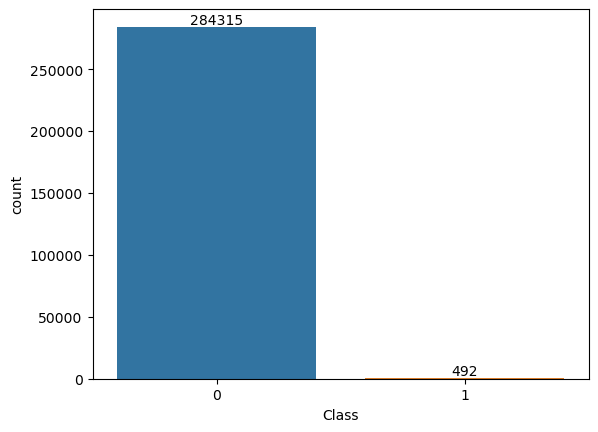

In [7]:
ax = sns.countplot(data=df, x='Class' )


for i in ax.containers:
    ax.bar_label(i,)

<Axes: >

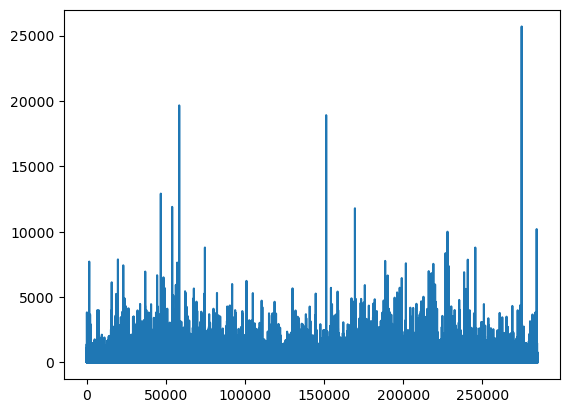

In [8]:
df['Amount'].plot(kind='line')

In [9]:
df["Amount"].values.shape

(284807,)

In [10]:
df["Amount"].values.reshape(-1, 1)

array([[149.62],
       [  2.69],
       [378.66],
       ...,
       [ 67.88],
       [ 10.  ],
       [217.  ]])

In [11]:
df['Amount'] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1, 1))

In [12]:
df['Amount'].describe()

count    2.848070e+05
mean     2.913952e-17
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount, dtype: float64

In [13]:
df0 = df[df['Class'] == 0].sample(20000)
df1 = df[df['Class'] == 1].sample(400)
df = pd.concat([df0, df1])

In [14]:
df['Class'].value_counts()

0    20000
1      400
Name: Class, dtype: int64

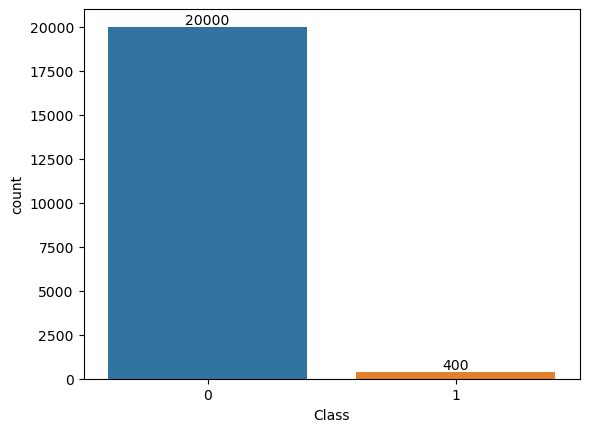

In [15]:
ax = sns.countplot(data=df, x='Class' )

for i in ax.containers:
    ax.bar_label(i,)

In [16]:
x_train, x_test, y_train, y_test = \
    train_test_split(df.drop(labels=['Time', 'Class'], axis=1), 
                     df['Class'], test_size=0.2, random_state=101)

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


## Create a simple auto encoder model

encoding_dim = 12
input_dim = x_train.shape[1]

input_array = Input(shape=(input_dim,))
encoded= Dense(encoding_dim, activation='relu')(input_array)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(input_array, decoded)
autoencoder.summary()

## Create a sparse auto encoder model

from keras import regularizers

encoding_dim = 12
input_dim = x_train.shape[1]

input_array = Input(shape=(input_dim,))
encoded= Dense(encoding_dim, activation='relu', 
               activity_regularizer=regularizers.l1(10e-5))(input_array)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(input_array, decoded)
autoencoder.summary()

## Create a Deep auto encoder model

In [17]:
from keras import regularizers

encoding_dim = 16
input_dim = x_train.shape[1]

input_array = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_array)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)


decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(input_array, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 16)                480       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 29)                493   

-----------------------

In [18]:
autoencoder.compile(optimizer=RMSprop(),
                   loss='mean_squared_error',
                   metrics=['mae', 'accuracy'])

### Load tensorboard via console
python -m tensorboard.main --logdir=d:\ds\dl\log\autoencoder1 --port=6007

In [19]:
# log_dir='d:/ds/dl/logs/autoencoder1/'
log_dir = os.path.join('D:', os.sep, 'DS', 'DL', 'Concepts', 'logs', 'auto-deep-02')
print(log_dir)

D:\DS\DL\Concepts\logs\auto-deep-02


In [20]:
# %load_ext tensorboard
# os.environ['TENSORBOARD_BINARY'] = r'c:\users\104974068\appdata\roaming\python\python310\site-packages'

In [21]:
# log_dir='../log/autoencoder1/'
?%tensorboard --logdir=log_dir


Object `%tensorboard --logdir=log_dir` not found.


In [22]:
# from tensorboard import notebook
# notebook.list()

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

callbacks = [TensorBoard(log_dir=log_dir,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]

In [24]:
batch_size = 64
epochs = 100

history = autoencoder.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         shuffle=True,
                         validation_data=(x_test, y_test),
                         callbacks=callbacks
                         )

Epoch 1/100
255/255 [==============================] - 1s 3ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 9.8039e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 0.0000e+00
Epoch 2/100
255/255 [==============================] - 0s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 5.5147e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 0.0000e+00
Epoch 3/100
255/255 [==============================] - 0s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 4.9020e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 4/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 4.9020e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 5/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 5.5147e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 6/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - m

255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 5.5147e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 46/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 5.5147e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 47/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 5.5147e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 48/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 4.9020e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 49/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 4.9020e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 50/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0

255/255 [==============================] - 1s 3ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 5.5147e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 90/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 5.5147e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 91/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 5.5147e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 92/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 6.1275e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 93/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0535 - accuracy: 6.7402e-04 - val_loss: 0.0165 - val_mae: 0.0498 - val_accuracy: 2.4510e-04
Epoch 94/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.0

In [25]:
history.history.keys()

dict_keys(['loss', 'mae', 'accuracy', 'val_loss', 'val_mae', 'val_accuracy'])

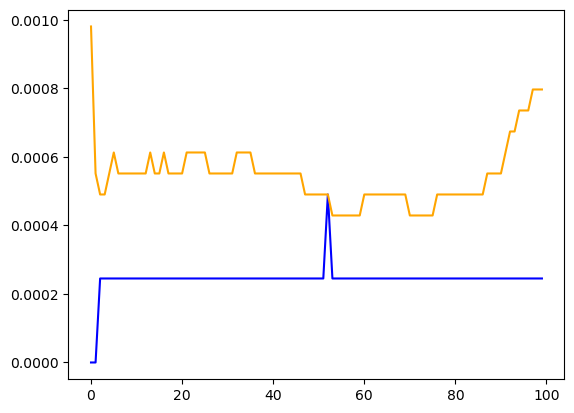

In [26]:
plt.plot(history.history['val_accuracy'], color='b')
plt.plot(history.history['accuracy'], color='orange')


In [27]:
# plt.plot(history.history['val_loss'], color='b')
# plt.plot(history.history['loss'], color='orange')

## Evaluation

In [28]:
score = autoencoder.evaluate(x_train, y_train, verbose=1)
print('Test loss:', score[0])
print('Test Accuracy:', score[1])


510/510 [==============================] - 0s 749us/step - loss: 0.0202 - mae: 0.0535 - accuracy: 7.9657e-04
Test loss: 0.020186355337500572
Test Accuracy: 0.05348006635904312


In [29]:
score

[0.020186355337500572, 0.05348006635904312, 0.0007965686381794512]

In [30]:
# measure anomalies based on a threshold
threshold = 20.00

y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)

y_label =[]
error = []

for index, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    
    error.append(y_dist)

128/128 [==============================] - 0s 682us/step


In [31]:
y_dist

4.930649607548449

In [32]:
viz = visualization()

In [33]:
roc_auc_score(y_test, y_label)

0.735317308300263

In [34]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4013
           1       0.53      0.48      0.50        67

    accuracy                           0.98      4080
   macro avg       0.76      0.74      0.75      4080
weighted avg       0.98      0.98      0.98      4080



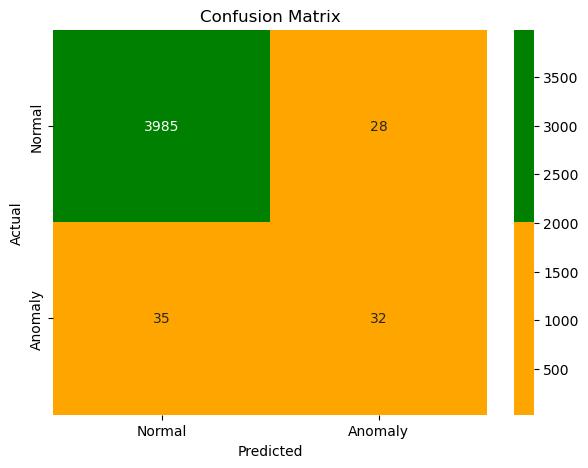

In [35]:
viz.draw_confusion_matrix(y_test, y_label)

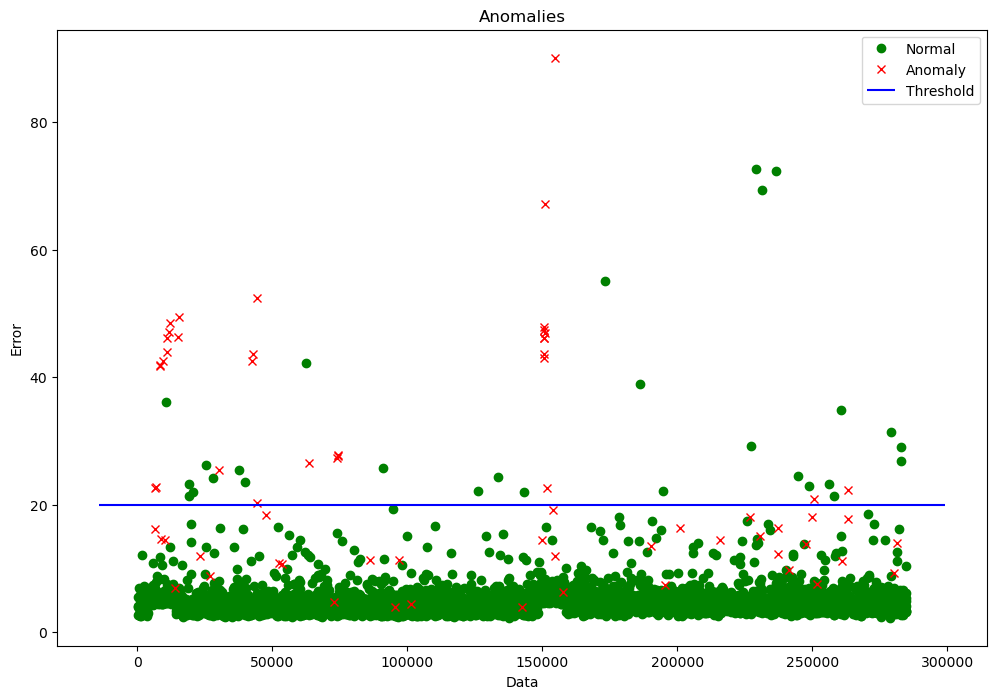

In [36]:
viz.draw_anomaly(y_test, error, threshold)

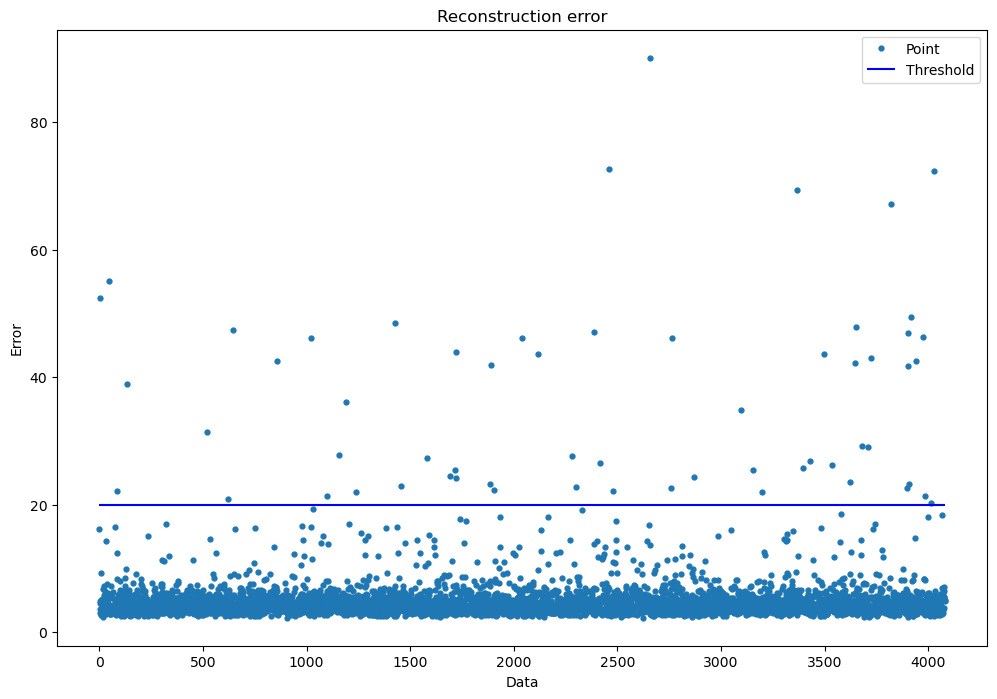

In [37]:
viz.draw_error(error, threshold)